## Data Exploration Drill 1

Use the same US Education dataset from Kaggle.  Apply the most suitable missing value filling techniques you applied in the previous checkpoint to the data. You're supposed to provide your answers to the following questions after you handled the missing values.

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1) Derive the descriptive statistics of the data and discuss the points you find remarkable.

2) Choose a state (e.g. California) and draw a line graph of its total revenues and total expenditures along the years. How do these 2 variables evolve during the years? Try to explain the peaks and troughs with some state-wise news and information around those dates.

3) In your chosen state, which of the lessons are the students more successful, math or reading?

4) What are the distributions of the math and reading scores in the sample?

Notice there are too many missing values for math and reading scores. Fill out the missing values using mean, median, and linear interpolation. Then compare the effects of these techniques on the distributions of the score variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics
import psycopg2
from sqlalchemy import create_engine
import warnings

In [2]:
#Connecting to Postgres database using sqlachemy
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
education_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

### 1) Clean the data by filling in missing values and then overcoming outliers

In [4]:
#Create a list called 'names' to fill in the missing values for revenues and students

names = ['ENROLL',
'TOTAL_REVENUE',                   
'FEDERAL_REVENUE',                 
'STATE_REVENUE',                   
'LOCAL_REVENUE',                   
'TOTAL_EXPENDITURE',              
'INSTRUCTION_EXPENDITURE',        
'SUPPORT_SERVICES_EXPENDITURE',    
'OTHER_EXPENDITURE',              
'CAPITAL_OUTLAY_EXPENDITURE',      
'GRADES_PK_G',                   
'GRADES_KG_G',                     
'GRADES_4_G',                      
'GRADES_8_G',                      
'GRADES_12_G',                     
'GRADES_1_8_G',                    
'GRADES_9_12_G',                   
'GRADES_ALL_G', 
'AVG_MATH_4_SCORE',
'AVG_MATH_8_SCORE',
'AVG_READING_4_SCORE',
'AVG_READING_8_SCORE'
        ]

#Then iterate using for loop for each column to fill in NaN values

for name in names:
    education_df["{}".format(name)] = education_df.groupby(['YEAR'])["{}".format(name)]\
        .transform(lambda x: x.fillna(x.mean()))

In [33]:
names = ['ENROLL',
'TOTAL_REVENUE',                   
'FEDERAL_REVENUE',                 
'STATE_REVENUE',                   
'LOCAL_REVENUE',                   
'TOTAL_EXPENDITURE',              
'INSTRUCTION_EXPENDITURE',        
'SUPPORT_SERVICES_EXPENDITURE',    
'OTHER_EXPENDITURE',              
'CAPITAL_OUTLAY_EXPENDITURE',      
'GRADES_PK_G',                   
'GRADES_KG_G',                     
'GRADES_4_G',                      
'GRADES_8_G',                      
'GRADES_12_G',                     
'GRADES_1_8_G',                    
'GRADES_9_12_G',                   
'GRADES_ALL_G', 
'AVG_MATH_4_SCORE',
'AVG_MATH_8_SCORE',
'AVG_READING_4_SCORE',
'AVG_READING_8_SCORE'
        ]

states = education_df['STATE'].unique()

for state in states:
    education_df.loc[education_df['STATE'] == state, names] = education_df.loc[education_df['STATE'] == state, names].interpolate()


In [34]:
#Now use interpolation to fill in missing remaining missing values

#for name in names:
#    education_df["{}".format(name)] = education_df["{}".format(name)]\
#        .interpolate(method='nearest', limit_direction='backward')

In [35]:
#Drop any remaining NaN values
education_df.dropna(inplace=True)

In [36]:
#Check to see % of missing values from first pass at missing values of .03
education_df.isnull().sum()/education_df.isnull().count()

PRIMARY_KEY                                0.0
STATE                                      0.0
YEAR                                       0.0
ENROLL                                     0.0
TOTAL_REVENUE                              0.0
FEDERAL_REVENUE                            0.0
STATE_REVENUE                              0.0
LOCAL_REVENUE                              0.0
TOTAL_EXPENDITURE                          0.0
INSTRUCTION_EXPENDITURE                    0.0
SUPPORT_SERVICES_EXPENDITURE               0.0
OTHER_EXPENDITURE                          0.0
CAPITAL_OUTLAY_EXPENDITURE                 0.0
GRADES_PK_G                                0.0
GRADES_KG_G                                0.0
GRADES_4_G                                 0.0
GRADES_8_G                                 0.0
GRADES_12_G                                0.0
GRADES_1_8_G                               0.0
GRADES_9_12_G                              0.0
GRADES_ALL_G                               0.0
AVG_MATH_4_SC

In [37]:
from scipy.stats.mstats import winsorize

# Apply one-way winsorization to the highest end of the value distribution. 
# will set the values of the outliers to the value of the 95th percentile. 

names = ['ENROLL','TOTAL_REVENUE',                   
'FEDERAL_REVENUE',                 
'STATE_REVENUE',                   
'LOCAL_REVENUE',                   
'TOTAL_EXPENDITURE',              
'INSTRUCTION_EXPENDITURE',        
'SUPPORT_SERVICES_EXPENDITURE',    
'OTHER_EXPENDITURE',              
'CAPITAL_OUTLAY_EXPENDITURE',      
'GRADES_PK_G',                   
'GRADES_KG_G',                     
'GRADES_4_G',                      
'GRADES_8_G',                      
'GRADES_12_G',                     
'GRADES_1_8_G',                    
'GRADES_9_12_G',                   
'GRADES_ALL_G',
'AVG_MATH_4_SCORE',
'AVG_MATH_8_SCORE',
'AVG_READING_4_SCORE',
'AVG_READING_8_SCORE'
        ]

#Then iterate using for loop for each column to winsorize the data

for name in names:
    education_df["winsorized_{}".format(name)] = winsorize_views= winsorize(education_df["{}".format(name)], (0.1, 0.1))

In [38]:
#Check to ensure everything worked!  
education_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1411 entries, 36 to 1446
Data columns (total 47 columns):
PRIMARY_KEY                                1411 non-null object
STATE                                      1411 non-null object
YEAR                                       1411 non-null int64
ENROLL                                     1411 non-null float64
TOTAL_REVENUE                              1411 non-null float64
FEDERAL_REVENUE                            1411 non-null float64
STATE_REVENUE                              1411 non-null float64
LOCAL_REVENUE                              1411 non-null float64
TOTAL_EXPENDITURE                          1411 non-null float64
INSTRUCTION_EXPENDITURE                    1411 non-null float64
SUPPORT_SERVICES_EXPENDITURE               1411 non-null float64
OTHER_EXPENDITURE                          1411 non-null float64
CAPITAL_OUTLAY_EXPENDITURE                 1411 non-null float64
GRADES_PK_G                                1411 non

### 2) Derive descriptive statistics of the cleaned data set

In [39]:
#Descriptive statistics for dataframe and rounding the numbers for ease of reading; then transpose output
np.round(education_df.describe(include= [np.number]), 0).T

,count,mean,std,min,25%,50%,75%,max
YEAR,1411.0,2004.0,7.0,1992.0,1998.0,2004.0,2010.0,2017.0
ENROLL,1411.0,909434.0,996658.0,43866.0,285666.0,735018.0,955898.0,6307022.0
TOTAL_REVENUE,1411.0,9183891.0,11166365.0,465650.0,2530496.0,5918536.0,11299762.0,89217262.0
FEDERAL_REVENUE,1411.0,777197.0,1092664.0,31714.0,215026.0,460902.0,905674.0,9990221.0
STATE_REVENUE,1411.0,4260786.0,5264162.0,0.0,1345014.0,2911249.0,5220582.0,50904567.0
LOCAL_REVENUE,1411.0,4145907.0,5212743.0,23917.0,915974.0,2471085.0,4995971.0,36105265.0
TOTAL_EXPENDITURE,1411.0,9290284.0,11385762.0,481665.0,2497687.0,5987680.0,11214776.0,85320133.0
INSTRUCTION_EXPENDITURE,1411.0,4808273.0,5980528.0,265549.0,1323352.0,3076873.0,5719300.0,43964520.0
SUPPORT_SERVICES_EXPENDITURE,1411.0,2706580.0,3187338.0,139963.0,759996.0,1758078.0,3375909.0,26058021.0
OTHER_EXPENDITURE,1411.0,425008.0,500749.0,11541.0,118602.0,305275.0,521782.0,3995951.0


In [40]:
len(education_df['ENROLL'].unique().tolist())

1247

### Observations from the decriptive statistics:

- Expenditures are greater than revenues
- Instruction expenditure seems to be about half of total expenditure
- There's a significant increase in students between pre-K and K; likely becuase pre-K is voluntary

### 3) Choose a state (e.g. California) and draw a line graph of its total revenues and total expenditures along the years. How do these 2 variables evolve during the years? Try to explain the peaks and troughs with some state-wise news and information around those dates.



In [41]:
#y1=education_df.loc[education_df.STATE =='TEXAS', 'TOTAL_REVENUE']
#y2=education_df.loc[education_df.STATE =='TEXAS', 'TOTAL_EXPENDITURE']
#x = education_df['YEAR']

#plt.plot(x, y1, y2)
#plt.legend()
#plt.show()

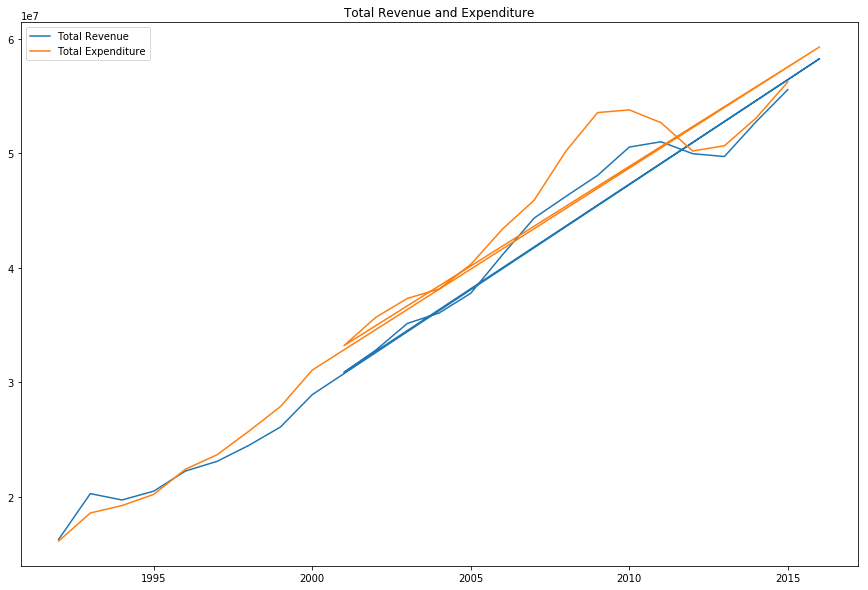

In [42]:
#Plot the revenues and expenditures for the selected state over the time period.
plt.figure(figsize=(15,10))

plt.plot(education_df.loc[education_df.STATE == "TEXAS", "YEAR"], 
         education_df.loc[education_df.STATE == "TEXAS", "TOTAL_REVENUE"], label="Total Revenue")

plt.plot(education_df.loc[education_df.STATE == "TEXAS", "YEAR"],
         education_df.loc[education_df.STATE == "TEXAS", "TOTAL_EXPENDITURE"], label="Total Expenditure")

plt.title("Total Revenue and Expenditure")
plt.legend()
plt.show()


### Takeaways from visualization

- Sometime arond 2010 expenditures increased while revenues seems to grow in a linear fashion.  Something happened
  perhaps post-recession the state spent more money on upgrading teacher's pay or other factors.

- Starting in around 1997, the schools starting spending more than their revenues entering into a deficit budgetary
  cycle that seems to have persisted for the past 13 years.

### 4) In your chosen state, which of the lessons are the students more successful, math or reading?

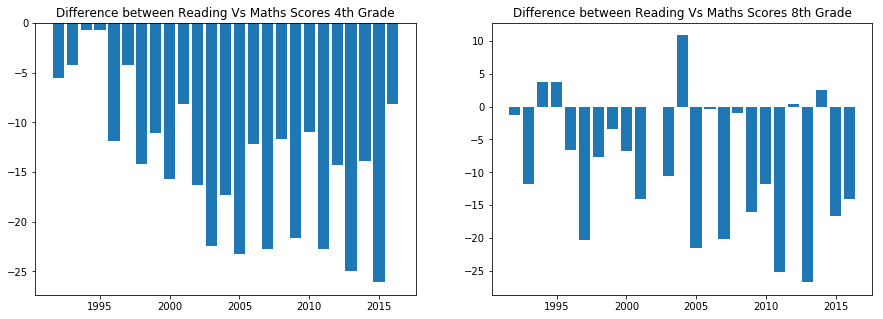

Delta between Reading & Math scores Grade 4
44      -5.524433
96      -4.192036
148     -0.726206
201     -0.726206
252    -11.850907
304     -4.185223
355    -14.201492
407    -11.061023
460    -15.733788
481     -8.122169
512     -8.122169
564    -16.260795
616    -22.497916
668    -17.319203
719    -23.257092
771    -12.131064
824    -22.735447
876    -11.689295
932    -21.606351
984    -11.012606
1036   -22.780949
1088   -14.285379
1140   -25.016692
1191   -13.928333
1242   -26.059559
dtype: float64
Delta between Reading & Math scores Grade 8
44      -1.285762
96     -11.773009
148      3.681578
201      3.681578
252     -6.607836
304    -20.255310
355     -7.626302
407     -3.380948
460     -6.755989
481    -14.002688
512    -14.002688
564     -0.068150
616    -10.486543
668     10.834657
719    -21.471485
771     -0.358128
824    -20.160498
876     -0.946647
932    -15.984540
984    -11.713007
1036   -25.227153
1088     0.339446
1140   -26.749917
1191     2.464710
1242   -16.7136

In [68]:
#Plot the math and reading scores for selected state to see which topic students are more advanced with

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.bar(education_df.loc[education_df.STATE == "TEXAS", "YEAR"], 
         education_df.loc[education_df.STATE == "TEXAS", "AVG_READING_4_SCORE"] -
         education_df.loc[education_df.STATE == "TEXAS", "AVG_MATH_4_SCORE"], label="Delta in Scores")
plt.title('Difference between Reading Vs Maths Scores 4th Grade')

plt.subplot(1,2,2)
plt.bar(education_df.loc[education_df.STATE == "TEXAS", "YEAR"], 
         education_df.loc[education_df.STATE == "TEXAS", "AVG_READING_8_SCORE"] -
         education_df.loc[education_df.STATE == "TEXAS", "AVG_MATH_8_SCORE"], label="Delta in Scores")
plt.title('Difference between Reading Vs Maths Scores 8th Grade')

plt.show()


Grade4_delta =  education_df.loc[education_df.STATE == "TEXAS", "AVG_READING_4_SCORE"] - education_df.loc[
    education_df.STATE == "TEXAS", "AVG_MATH_4_SCORE"]

Grade8_delta =  education_df.loc[education_df.STATE == "TEXAS", "AVG_READING_8_SCORE"] - education_df.loc[
    education_df.STATE == "TEXAS", "AVG_MATH_8_SCORE"]


print('Delta between Reading & Math scores Grade 4')
print(Grade4_delta)
print('Delta between Reading & Math scores Grade 8')
print(Grade8_delta)

### 4) In your chosen state, which of the lessons are the students more successful, math or reading?

- It appears that in the state of Texas, students score better in Math than in Reading in 4th grade and for the most part that trend continues in 8th grade with the exception of a couple of years wherein reading scores were better than math scores